In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt

import seaborn as sns
seed = 7
np.random.seed(seed)

In [2]:
d1=pd.read_csv("CleanedDataset.csv")
d1.columns
d1.columns
d1.shape

(522252, 5)

In [3]:
d1.head()

,Sequence,P_1,Q_1,V_1,I_1
0,0,4.216,0.418,234.84,18.4
1,1,5.360,0.436,233.63,23.0
2,2,5.374,0.498,233.29,23.0
3,3,5.388,0.502,233.74,23.0
4,4,3.666,0.528,235.68,15.8


In [4]:
for label,content in d1.items():
    if label != 'Sequence':
        d1[label]=d1[label].fillna(d1[label].mean())
        


In [5]:
d1['Sequence']=pd.to_datetime(d1['Sequence'])
d1.set_index(d1['Sequence'], inplace = True) 
d1=d1.drop(['Sequence'],axis=1)

In [6]:
d1.head()

,P_1,Q_1,V_1,I_1
Sequence,,,,
1970-01-01 00:00:00.000000000,4.216,0.418,234.84,18.4
1970-01-01 00:00:00.000000001,5.360,0.436,233.63,23.0
1970-01-01 00:00:00.000000002,5.374,0.498,233.29,23.0
1970-01-01 00:00:00.000000003,5.388,0.502,233.74,23.0
1970-01-01 00:00:00.000000004,3.666,0.528,235.68,15.8


In [7]:
d1.dtypes

P_1    float64
Q_1    float64
V_1    float64
I_1    float64
dtype: object

In [8]:
d1=d1.sort_values(by=['Sequence'])

In [9]:
d1.head(10)

,P_1,Q_1,V_1,I_1
Sequence,,,,
1970-01-01 00:00:00.000000000,4.216,0.418,234.84,18.4
1970-01-01 00:00:00.000000001,5.360,0.436,233.63,23.0
1970-01-01 00:00:00.000000002,5.374,0.498,233.29,23.0
1970-01-01 00:00:00.000000003,5.388,0.502,233.74,23.0
1970-01-01 00:00:00.000000004,3.666,0.528,235.68,15.8
1970-01-01 00:00:00.000000005,3.520,0.522,235.02,15.0
1970-01-01 00:00:00.000000006,3.702,0.520,235.09,15.8
1970-01-01 00:00:00.000000007,3.700,0.520,235.22,15.8
1970-01-01 00:00:00.000000008,3.668,0.510,233.99,15.8


In [10]:
#d1 = d1.set_index('date')
print(d1.shape)

(522252, 4)


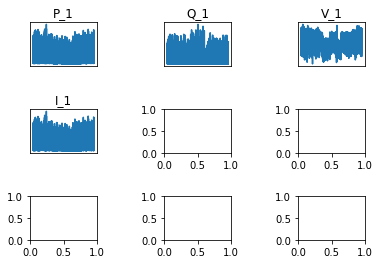

In [11]:
groups = [0, 1, 2, 3]
values = d1.values
fig,sub = plt.subplots(3,3)
plt.subplots_adjust(wspace=1, hspace=1)

for ax, i in zip(sub.flatten(),groups):
    ax.plot(values[:,i])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(d1.columns[i])

In [12]:
data=d1
data

,P_1,Q_1,V_1,I_1
Sequence,,,,
1970-01-01 00:00:00.000000000,4.216,0.418,234.84,18.4
1970-01-01 00:00:00.000000001,5.360,0.436,233.63,23.0
1970-01-01 00:00:00.000000002,5.374,0.498,233.29,23.0
1970-01-01 00:00:00.000000003,5.388,0.502,233.74,23.0
1970-01-01 00:00:00.000000004,3.666,0.528,235.68,15.8
...,...,...,...,...
1970-01-01 00:00:00.000522247,0.276,0.046,247.45,1.2
1970-01-01 00:00:00.000522248,0.222,0.000,247.80,0.8
1970-01-01 00:00:00.000522249,0.220,0.000,247.36,0.8


In [13]:
#convert data to supervised form

def to_supervised(data,dropNa = True,lag = 1):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

In [14]:
timeSteps = 2

# supervised = to_supervised(scaled,lag=timeSteps)
supervised = to_supervised(data,lag=timeSteps)
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8
0,4.216,0.418,234.84,18.4,5.360,0.436,233.63,23.0,5.374
1,5.360,0.436,233.63,23.0,5.374,0.498,233.29,23.0,5.388
2,5.374,0.498,233.29,23.0,5.388,0.502,233.74,23.0,3.666
3,5.388,0.502,233.74,23.0,3.666,0.528,235.68,15.8,3.520
4,3.666,0.528,235.68,15.8,3.520,0.522,235.02,15.0,3.702


In [15]:
# spiltting the data
# training on only first year data
features = data.shape[1]
train_hours = 365*1000
X = supervised[:,:features*timeSteps]
y = np.array([supervised[:,features*2],supervised[:,5]])
y=y.reshape(522250,2)

x_train = X[:train_hours,:]
y_train = y[:train_hours]

y_test = y[train_hours:train_hours+78337]
x_test = X[train_hours:train_hours+78337,:]

y_val = y[train_hours+78337:]
x_val = X[train_hours+78337:,:]

print( x_train.shape,x_test.shape,y_train.shape,y_test.shape,x_val.shape,y_val.shape)

(365000, 8) (78337, 8) (365000, 2) (78337, 2) (78913, 8) (78913, 2)


In [16]:
#convert data                    to fit for lstm
#dimensions = (sample, timeSteps here it is 1, features )

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print( x_train.shape,x_test.shape)

(365000, 2, 4) (78337, 2, 4)


In [17]:
#define the model
from keras.layers import Dropout
import keras
import tensorflow as tf

model = Sequential()
model.add( LSTM( 10, input_shape = ( timeSteps,x_train.shape[2]),activation="sigmoid" ) )
model.add(Dropout(0.2))
model.add(Dense(2))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

history =  model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs=10, batch_size=32, verbose=1, shuffle = False)

Epoch 1/10
11407/11407 [==============================] - 19s 2ms/step - loss: 0.9508 - root_mean_squared_error: 0.9751 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 2/10
11407/11407 [==============================] - 24s 2ms/step - loss: 0.9439 - root_mean_squared_error: 0.9715 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 3/10
11407/11407 [==============================] - 31s 3ms/step - loss: 0.9439 - root_mean_squared_error: 0.9716 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 4/10
11407/11407 [==============================] - 33s 3ms/step - loss: 0.9432 - root_mean_squared_error: 0.9712 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 5/10
11407/11407 [==============================] - 47s 4ms/step - loss: 0.9439 - root_mean_squared_error: 0.9715 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 6/10
11407/11407 [==============================] - 38s 3ms/step - loss: 0.9434 - root_mean_squared_error: 0.

In [18]:
model.save("test_new.h5")

In [19]:
#scale back the prediction to orginal scale
y_pred = model.predict(x_test[:100])
print("pred",y_pred[:100])
print("test",y_test[:100])


final_pred=y_pred.reshape(100,2)
final_actual=y_test[:100].reshape(100,2)

pred [[0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498464]
 [0.12839419 0.12498

In [24]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print (mean_absolute_error(final_pred,final_actual) )
print ((mean_squared_error(final_pred,final_actual)))

0.055034552218914054
0.004175464892880168


0.06461783726557371